In [ ]:
import torch

# Check PyTorch version and CUDA availability
TORCH_VERSION = torch.__version__
CUDA_VERSION = torch.version.cuda
print(f"PyTorch Version: {TORCH_VERSION}")
print(f"CUDA Version: {CUDA_VERSION}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Current device: {torch.cuda.get_device_name(0)}")

# Install torch-scatter, torch-sparse, and torch-geometric
# These need to match the PyTorch and CUDA versions in your Colab runtime.
# We'll use a dynamic approach to get the correct wheels.
# Source: https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html



def format_cuda_version(version):
    return 'cu' + version.replace('.', '')

# Get PyTorch and CUDA versions dynamically
# TORCH = format_pytorch_version(TORCH_VERSION)
CUDA = format_cuda_version(CUDA_VERSION)

# print(f"Installing PyG with TORCH={TORCH} and CUDA={CUDA}...")

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.5.0+cu124.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-2.5.0+cu124.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-2.5.0+cu124.html # Often useful for sampling
!pip install -q torch-geometric
!pip install -q ogb

print("\nInstallation complete. Restarting runtime might be necessary sometimes but let's try proceeding.")

PyTorch Version: 2.5.1+cu124
CUDA Version: 12.4
CUDA available: True
Current device: Tesla T4

Installation complete. Restarting runtime might be necessary sometimes but let's try proceeding.


In [ ]:
!pip uninstall torch torch-scatter torch-sparse torch-geometric torch-cluster torch-spline-conv -y

Found existing installation: torch 2.5.1
Uninstalling torch-2.5.1:
  Successfully uninstalled torch-2.5.1
Found existing installation: torch_scatter 2.1.2+pt25cu121
Uninstalling torch_scatter-2.1.2+pt25cu121:
  Successfully uninstalled torch_scatter-2.1.2+pt25cu121
Found existing installation: torch_sparse 0.6.18+pt25cu121
Uninstalling torch_sparse-0.6.18+pt25cu121:
  Successfully uninstalled torch_sparse-0.6.18+pt25cu121
Found existing installation: torch-geometric 2.6.1
Uninstalling torch-geometric-2.6.1:
  Successfully uninstalled torch-geometric-2.6.1
Found existing installation: torch_cluster 1.6.3+pt25cu121
Uninstalling torch_cluster-1.6.3+pt25cu121:
  Successfully uninstalled torch_cluster-1.6.3+pt25cu121
Found existing installation: torch_spline_conv 1.2.2+pt25cu121
Uninstalling torch_spline_conv-1.2.2+pt25cu121:
  Successfully uninstalled torch_spline_conv-1.2.2+pt25cu121


In [3]:
!pip install ogb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 7.3 MB/s eta 0:00:00


In [1]:
!pip install torch==2.5.1 torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.5.0+cpu.html

Looking in links: https://data.pyg.org/whl/torch-2.5.0+cpu.html


# Combined Code

In [4]:
# Cell 1: Colab Environment Setup & Core Imports

import torch
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import random
import matplotlib.pyplot as plt

# PyTorch Geometric specific imports (these will be installed)
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv, GCNConv
from torch_geometric.utils import subgraph

# OGB (Open Graph Benchmark) specific imports
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator

# Additional imports for analysis and utility
from collections import Counter
from tqdm import tqdm

# Setting the seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
# torch.backends.cudnn.deterministic = True # Uncomment for stricter reproducibility, might slow down training

print("--- Initializing Environment ---")

# Check PyTorch version and CUDA availability
TORCH_VERSION = torch.__version__
CUDA_VERSION = torch.version.cuda
print(f"PyTorch Version: {TORCH_VERSION}")
print(f"CUDA Version: {CUDA_VERSION}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Define device (GPU if available, else CPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device) # Convert string to torch.device object
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"Current device name: {torch.cuda.get_device_name(0)}")

# Dynamic PyG installation based on detected PyTorch and CUDA versions
def format_pytorch_version(version):
    return version.split('+')[0]

def format_cuda_version(version):
    return 'cu' + version.replace('.', '')

TORCH = format_pytorch_version(TORCH_VERSION)
CUDA = format_cuda_version(CUDA_VERSION)

print(f"\nAttempting to install PyG with TORCH={TORCH} and CUDA={CUDA}...")
# Using %%capture to hide the lengthy pip output
get_ipython().run_cell_magic('capture', '', f'!pip install ogb pyg-lib torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html\n!pip install torch-geometric')

print("Installation commands sent. Checking for essential imports...")

# Verify essential imports now that installations are theoretically done
try:
    from torch_geometric.nn import SAGEConv # Check a key PyG module
    from ogb.nodeproppred import PygNodePropPredDataset # Check an OGB module
    print("\nEssential libraries imported successfully.")
except ImportError as e:
    print(f"ERROR: Failed to import required libraries after installation: {e}")
    print("This often means Colab needs a runtime restart after installations.")
    print("Please go to 'Runtime' -> 'Restart runtime' and then rerun ALL cells from the beginning.")

print("\nCell 1: Environment setup and imports complete.")

--- Initializing Environment ---
PyTorch Version: 2.5.1+cu124
CUDA Version: 12.4
CUDA available: False
Using device: cpu

Attempting to install PyG with TORCH=2.5.1 and CUDA=cu124...
Installation commands sent. Checking for essential imports...

Essential libraries imported successfully.

Cell 1: Environment setup and imports complete.


In [5]:
# Cell 2: Load OGBN-Products & Create Manageable Subgraph

# Path for OGBN-Products dataset. Using /content/ as root in Colab.
# A distinct path to prevent conflicts if 'ogb_data' was used before.
ROOT_DIR_OGBN = '/content/ogb_products_data_subset_larger' # New distinct path
if not os.path.exists(ROOT_DIR_OGBN):
    os.makedirs(ROOT_DIR_OGBN)

def load_ogbn_products_and_create_subgraph(root_dir: str = ROOT_DIR_OGBN, subset_node_count: int = 150_000) -> tuple[Data, Data, torch.Tensor]:
    """
    Loads the full ogbn-products dataset and extracts a larger subgraph for prototyping.

    Returns:
        tuple: (full_graph_data, subgraph_data, subset_indices_ogbn)
    """
    print(f"Loading ogbn-products dataset into {root_dir}...")
    dataset = PygNodePropPredDataset(name='ogbn-products', root=root_dir)
    full_graph_data = dataset[0] # The full OGBN-Products graph Data object
    print(f"Full OGBN-Products dataset loaded. Nodes: {full_graph_data.num_nodes}, Edges: {full_graph_data.num_edges}")

    # Create a reproducible subset of nodes (e.g., first N nodes)
    actual_subset_node_count = min(subset_node_count, full_graph_data.num_nodes)
    subset_indices_ogbn = torch.arange(0, actual_subset_node_count)
    print(f"Creating a subgraph with {actual_subset_node_count} nodes...")

    # Extract the subgraph corresponding to the subset
    subset_edge_index, _, _ = subgraph(
        subset_indices_ogbn, full_graph_data.edge_index, None,
        relabel_nodes=True,
        num_nodes=full_graph_data.num_nodes,
        return_edge_mask=True
    )

    # Adjust node features and labels for the subset
    subset_features = full_graph_data.x[subset_indices_ogbn]
    subset_labels = full_graph_data.y[subset_indices_ogbn]

    # Create a new Data object for the subgraph
    subgraph_data = Data(x=subset_features, edge_index=subset_edge_index, y=subset_labels)

    # Add masks to the subgraph_data for training, validation, and test.
    def generate_split_masks(num_nodes: int, train_frac: float = 0.6, val_frac: float = 0.2, test_frac: float = 0.2):
        assert train_frac + val_frac + test_frac == 1.0, "Fractions must sum up to 1."
        indices = torch.randperm(num_nodes)

        train_size = int(num_nodes * train_frac)
        val_size = int(num_nodes * val_frac)

        train_mask = torch.zeros(num_nodes, dtype=torch.bool)
        val_mask = torch.zeros(num_nodes, dtype=torch.bool)
        test_mask = torch.zeros(num_nodes, dtype=torch.bool)

        train_mask[indices[:train_size]] = True
        val_mask[indices[train_size:train_size + val_size]] = True
        test_mask[indices[train_size + val_size:]] = True
        return {'train_mask': train_mask, 'val_mask': val_mask, 'test_mask': test_mask}

    split_masks = generate_split_masks(num_nodes=subgraph_data.num_nodes)
    subgraph_data.train_mask = split_masks['train_mask']
    subgraph_data.val_mask = split_masks['val_mask']
    subgraph_data.test_mask = split_masks['test_mask']

    # Ensure 'y' is a 1D tensor of class labels and define num_features/num_classes
    subgraph_data.y = subgraph_data.y.squeeze()
    subgraph_data.num_features = subgraph_data.x.size(1)
    subgraph_data.num_classes = int(subgraph_data.y.max().item()) + 1

    print(f"Subgraph created with {subgraph_data.num_nodes} nodes and {subgraph_data.num_edges} edges.")
    print(f"Subgraph node features shape: {subgraph_data.x.shape}")
    print(f"Subgraph labels shape: {subgraph_data.y.shape}")
    print(f"Subgraph has {subgraph_data.num_classes} classes and {subgraph_data.num_features} features.")
    print(f"Train/Val/Test split for subgraph: Train={subgraph_data.train_mask.sum().item()}, "
          f"Val={subgraph_data.val_mask.sum().item()}, Test={subgraph_data.test_mask.sum().item()}")

    return full_graph_data, subgraph_data, subset_indices_ogbn


# Execute loading and subgraph creation
ogbn_full_graph, subset_graph, subset_indices_ogbn = load_ogbn_products_and_create_subgraph(subset_node_count=150_000)

print("\nCell 2: OGBN data loading and larger subgraph creation complete.")

Loading ogbn-products dataset into /content/ogb_products_data_subset_larger...
This will download 1.38GB. Will you proceed? (y/N)
y


Downloaded 1.38 GB: 100%|██████████| 1414/1414 [00:57<00:00, 24.53it/s]


Extracting /content/ogb_products_data_subset_larger/products.zip


Processing...


Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


Converting graphs into PyG objects...


100%|██████████| 1/1 [00:00<00:00, 129.59it/s]


Saving...


Done!
/usr/local/lib/python3.11/dist-packages/ogb/nodeproppred/dataset_pyg.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.proc

Full OGBN-Products dataset loaded. Nodes: 2449029, Edges: 123718280
Creating a subgraph with 150000 nodes...
Subgraph created with 150000 nodes and 6363432 edges.
Subgraph node features shape: torch.Size([150000, 100])
Subgraph labels shape: torch.Size([150000])
Subgraph has 40 classes and 100 features.
Train/Val/Test split for subgraph: Train=90000, Val=30000, Test=30000

Cell 2: OGBN data loading and larger subgraph creation complete.


In [24]:
# Cell 3 (Revised - Fix popularity_score): Load Product Mappings & Create Smart Kart DataFrames

# Paths to mapping files within the OGBN dataset structure
# Note: Using 'dataset' subdirectory for robustness as OGB usually unpacks there.
path_to_label_file = os.path.join(ROOT_DIR_OGBN, 'ogbn_products', 'mapping', 'labelidx2productcategory.csv.gz')
path_to_asin_file = os.path.join(ROOT_DIR_OGBN, 'ogbn_products', 'mapping', 'nodeidx2asin.csv.gz')

print(f"\nLoading label mappings from {path_to_label_file}...")
df_labels = pd.read_csv(path_to_label_file)
index_product_category_dict = dict(zip(df_labels['label idx'], df_labels['product category']))
print(f"Loaded {len(index_product_category_dict)} product categories.")

print(f"Loading node to ASIN mapping from {path_to_asin_file}...")
df_asin = pd.read_csv(path_to_asin_file)
node_asin_dict = dict(zip(df_asin['node idx'], df_asin['asin']))
print(f"Loaded {len(node_asin_dict)} ASIN mappings.")

# Create mappings between subgraph local indices and original OGBN global indices/ASINs
subgraph_local_idx_to_ogbn_global_idx = {i: original_idx.item() for i, original_idx in enumerate(subset_indices_ogbn)}
ogbn_global_idx_to_subgraph_local_idx = {v: k for k, v in subgraph_local_idx_to_ogbn_global_idx.items()}

# Create Smart Kart product IDs from the subgraph's local indices (e.g., 'prod_0000' to 'prod_149999')
sk_product_ids_subset = [f'prod_{i:06d}' for i in range(subset_graph.num_nodes)]

# Create mapping between Smart Kart product IDs and subgraph local indices
sk_prod_id_to_subgraph_local_idx = {pid: i for i, pid in enumerate(sk_product_ids_subset)}
subgraph_local_idx_to_sk_prod_id = {i: pid for i, pid in enumerate(sk_product_ids_subset)}


def create_smart_kart_product_df_from_subgraph(
    subgraph_data: Data,
    sk_prod_id_map: dict,
    category_map: dict,
    asin_map: dict,
    subgraph_local_to_global_idx_map: dict
) -> pd.DataFrame:
    """
    Creates a Smart Kart products DataFrame using information from the subgraph.
    """
    print("\nCreating Smart Kart Product DataFrame from Subgraph data...")
    products_data = []
    for local_idx in range(subgraph_data.num_nodes):
        sk_prod_id = sk_prod_id_map[local_idx]
        category_label = subgraph_data.y[local_idx].item()

        category_name = category_map.get(category_label, f"Unknown_Category_{category_label}")

        original_ogbn_idx = subgraph_local_to_global_idx_map[local_idx]
        asin = asin_map.get(original_ogbn_idx, f"UNKNOWN_ASIN_{original_ogbn_idx}")

        products_data.append({
            'product_id': sk_prod_id,
            'category_label_numeric': category_label,
            'category_name': category_name,
            'original_ogbn_idx': original_ogbn_idx,
            'asin': asin,
            'available_quantity': np.random.randint(0, 500),
            # --- FIX: Add initial popularity_score here ---
            # Assign a random float between 0.1 and 1.0 to simulate varying popularity
            # This ensures the column always exists.
            'popularity_score': np.random.uniform(0.1, 1.0)
        })

    products_df = pd.DataFrame(products_data)
    print(f"Created Smart Kart Products DataFrame with {len(products_df)} entries.")
    return products_df

smart_kart_products_df = create_smart_kart_product_df_from_subgraph(
    subset_graph,
    subgraph_local_idx_to_sk_prod_id,
    index_product_category_dict,
    node_asin_dict,
    subgraph_local_idx_to_ogbn_global_idx
)

print("\nSmart Kart Products DataFrame Head (from Subgraph):")
print(smart_kart_products_df.head())


# Simulate User, Session, and Current Cart Data
def simulate_smart_kart_user_session_cart_data(
    num_users: int = 5000,
    num_sessions: int = 10000,
    avg_items_per_session: int = 4,
    avg_items_per_cart: int = 3,
    max_items_per_session: int = 10,
    max_items_per_cart: int = 8,
    product_ids_list: list = None
) -> dict:
    if product_ids_list is None:
        raise ValueError("product_ids_list must be provided.")

    print("\nSimulating Smart Kart User, Session, and Cart data...")
    total_products_available = len(product_ids_list)

    users_df = pd.DataFrame({
        'user_id': [f'user_{i:05d}' for i in range(num_users)],
        'age': np.random.randint(18, 70, num_users),
        'gender': np.random.choice(['Male', 'Female', 'Other'], num_users, p=[0.45, 0.5, 0.05]),
        'loyalty_tier': np.random.choice(['Bronze', 'Silver', 'Gold', 'Platinum'], num_users, p=[0.4, 0.3, 0.2, 0.1])
    })
    print(f"Generated {len(users_df)} users.")

    sessions_data = []
    current_time = datetime.now()
    for i in tqdm(range(num_sessions), desc="Simulating Sessions"):
        user_id = np.random.choice(users_df['user_id'])
        session_start_time = current_time - timedelta(days=np.random.randint(0, 30),
                                                      hours=np.random.randint(0, 23),
                                                      minutes=np.random.randint(0, 59))

        num_items_in_session = max(1, int(np.random.normal(avg_items_per_session, 1.5)))
        num_items_in_session = min(num_items_in_session, total_products_available, max_items_per_session)

        session_products = np.random.choice(product_ids_list, num_items_in_session, replace=False).tolist()
        sessions_data.append({
            'session_id': f'sess_{i:07d}',
            'user_id': user_id,
            'start_time': session_start_time,
            'end_time': session_start_time + timedelta(minutes=np.random.randint(5, 60)),
            'product_ids': session_products
        })
    sessions_df = pd.DataFrame(sessions_data)
    sessions_exploded_df = sessions_df.explode('product_ids').rename(columns={'product_ids': 'product_id'})
    print(f"\nGenerated {len(sessions_df)} unique sessions.")

    current_carts_data = []
    num_active_carts = num_users // 4
    active_users = np.random.choice(users_df['user_id'], num_active_carts, replace=False)
    for i, user_id in enumerate(tqdm(active_users, desc="Simulating Carts")):
        num_items = max(1, int(np.random.normal(avg_items_per_cart, 0.5)))
        num_items = min(num_items, total_products_available, max_items_per_cart)

        cart_products = np.random.choice(product_ids_list, num_items, replace=False).tolist()
        current_carts_data.append({
            'user_id': user_id,
            'cart_id': f'cart_{i:07d}',
            'timestamp': datetime.now(),
            'product_ids': cart_products
        })
    current_carts_df = pd.DataFrame(current_carts_data)
    current_carts_exploded_df = current_carts_df.explode('product_ids').rename(columns={'product_ids': 'product_id'})
    print(f"\nGenerated {len(current_carts_df)} current carts.")
    return {
        'users': users_df,
        'sessions': sessions_df,
        'sessions_exploded': sessions_exploded_df,
        'current_carts': current_carts_df,
        'current_carts_exploded': current_carts_exploded_df
    }

smart_kart_aux_data = simulate_smart_kart_user_session_cart_data(
    product_ids_list=smart_kart_products_df['product_id'].tolist()
)

# Combine all data into one comprehensive dictionary
smart_kart_data = {
    'ogbn_full_graph': ogbn_full_graph,
    'subset_graph': subset_graph,
    'sk_products': smart_kart_products_df,
    **smart_kart_aux_data,
    'index_product_category_dict': index_product_category_dict,
    'node_asin_dict': node_asin_dict,
    'subgraph_local_idx_to_ogbn_global_idx': subgraph_local_idx_to_ogbn_global_idx,
    'ogbn_global_idx_to_subgraph_local_idx': ogbn_global_idx_to_subgraph_local_idx,
    'sk_prod_id_to_subgraph_local_idx': sk_prod_id_to_subgraph_local_idx,
    'subgraph_local_idx_to_sk_prod_id': subgraph_local_idx_to_sk_prod_id
}

print("\n--- Final Smart Kart Data Summary ---")
print(f"Number of Smart Kart products (from subgraph): {len(smart_kart_data['sk_products'])}")
print(f"Number of simulated users: {len(smart_kart_data['users'])}")
print(f"Number of simulated sessions: {len(smart_kart_data['sessions'])}")
print("\nSample Smart Kart Products (first 5 rows):")
print(smart_kart_data['sk_products'].head())
print("\nSample Simulated User Sessions (first 5 rows):")
print(smart_kart_data['sessions'].head())
print("\nSample Simulated Current Carts (first 5 rows):")
print(smart_kart_data['current_carts'].head())

print("\nCell 3: Product mappings and all Smart Kart DataFrames created (with robust np.random.choice optimization).")


Loading label mappings from /content/ogb_products_data_subset_larger/ogbn_products/mapping/labelidx2productcategory.csv.gz...
Loaded 47 product categories.
Loading node to ASIN mapping from /content/ogb_products_data_subset_larger/ogbn_products/mapping/nodeidx2asin.csv.gz...
Loaded 2449029 ASIN mappings.

Creating Smart Kart Product DataFrame from Subgraph data...
Created Smart Kart Products DataFrame with 150000 entries.

Smart Kart Products DataFrame Head (from Subgraph):
    product_id  category_label_numeric           category_name  \
0  prod_000000                       0          Home & Kitchen   
1  prod_000001                       1  Health & Personal Care   
2  prod_000002                       2                  Beauty   
3  prod_000003                       3       Sports & Outdoors   
4  prod_000004                       3       Sports & Outdoors   

   original_ogbn_idx        asin  available_quantity  popularity_score  
0                  0  B00902X3L2                 2

Simulating Sessions: 100%|██████████| 10000/10000 [06:13<00:00, 26.74it/s]



Generated 10000 unique sessions.


Simulating Carts: 100%|██████████| 1250/1250 [00:47<00:00, 26.24it/s]


Generated 1250 current carts.

--- Final Smart Kart Data Summary ---
Number of Smart Kart products (from subgraph): 150000
Number of simulated users: 5000
Number of simulated sessions: 10000

Sample Smart Kart Products (first 5 rows):
    product_id  category_label_numeric           category_name  \
0  prod_000000                       0          Home & Kitchen   
1  prod_000001                       1  Health & Personal Care   
2  prod_000002                       2                  Beauty   
3  prod_000003                       3       Sports & Outdoors   
4  prod_000004                       3       Sports & Outdoors   

   original_ogbn_idx        asin  available_quantity  popularity_score  
0                  0  B00902X3L2                 213          0.959863  
1                  1  B000FW4BGM                 242          0.572063  
2                  2  B001NTYWFQ                 121          0.578618  
3                  3  B003DTLNVA                 186          0.707010  
4 

In [25]:
# Cell 4 (Revised - Aggressive Fix for Dimensions): Define GNN Models

import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, GCNConv

# GCN Model definition (kept for reference)
class GCN(torch.nn.Module):
    def __init__(self, in_channels: int, hidden_channels: int, out_channels: int):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor, return_embeds: bool = False) -> torch.Tensor:
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        embeddings = self.conv2(x, edge_index)

        if return_embeds:
            return embeddings
        return F.log_softmax(embeddings, dim=1)

# Basic GraphSAGE Model definition (kept for reference)
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels: int, hidden_channels: int, out_channels: int, dropout: float = 0.5):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor, return_embeds: bool = False) -> torch.Tensor:
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        embeddings = self.conv2(x, edge_index)

        if return_embeds:
            return embeddings
        return F.log_softmax(embeddings, dim=1)


# Corrected Model: GraphSAGE with Custom Dropout and Flexible Aggregation
class GraphSAGEWithCustomDropout(torch.nn.Module):
    def __init__(self, in_channels: int, hidden_channels: int, out_channels: int,
                 num_layers: int = 2, dropout_rate: float = 0.5, aggr='mean'):
        super(GraphSAGEWithCustomDropout, self).__init__()
        self.dropout_rate = dropout_rate
        self.aggr = aggr

        # First SAGEConv layer
        self.conv1 = SAGEConv(in_channels, hidden_channels, aggr=aggr)

        # Assuming SAGEConv with `aggr=list` (MultiAggregation)
        # implicitly projects down to `out_channels` (here, `hidden_channels`)
        # before outputting, or that the error traceback is misleading.
        # The `mat1` shape `150000x64` strongly implies `conv1` outputs `64` features.

        # So, the input to conv2 should simply be `hidden_channels`.
        conv2_input_features = hidden_channels

        # The second layer uses `mean` aggregation as a standard way to get a single output per node
        # if the first layer did multi-aggregation, to then feed into `out_channels` (num_classes).
        # We ensure `out_channels` is the actual output dimension for classification.
        self.conv2 = SAGEConv(conv2_input_features, out_channels, aggr='mean') # Force 'mean' for last layer

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor, return_embeds: bool = False) -> torch.Tensor:
        # First layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_rate, training=self.training)

        # Second layer - this output is the final embedding before classification head
        embeddings = self.conv2(x, edge_index)

        if return_embeds:
            return embeddings # Return raw embeddings for FAISS

        return F.log_softmax(embeddings, dim=1) # Logits for classification loss

print("Cell 4: GNN Model architectures defined. Aggressive fix for GraphSAGEWithCustomDropout dimensions applied.")

Cell 4: GNN Model architectures defined. Aggressive fix for GraphSAGEWithCustomDropout dimensions applied.


In [26]:
# Cell 5: Training and Evaluation Functions

criterion = torch.nn.CrossEntropyLoss() # Cross-entropy loss for multi-class classification

def train_model(model: torch.nn.Module, data: Data, optimizer: torch.optim.Optimizer) -> float:
    """
    Trains a GNN model for one epoch.
    """
    model.train() # Set the model to training mode
    optimizer.zero_grad() # Clear gradients from previous step

    # Ensure data (features and edge_index) are on the correct device
    x = data.x.to(device)
    edge_index = data.edge_index.to(device)
    y = data.y.to(device) # Labels also on device

    # Forward pass: get logits for classification
    out = model(x, edge_index, return_embeds=False) # Get logits for loss calculation

    # Calculate loss only on the training mask
    loss = criterion(out[data.train_mask], y[data.train_mask])

    loss.backward() # Backpropagate the loss
    optimizer.step() # Update model parameters

    return loss.item() # Return the scalar loss value

def evaluate_model(model: torch.nn.Module, data: Data, mask: torch.Tensor, evaluator: Evaluator = None) -> tuple[float, float]:
    """
    Evaluates a GNN model on a given mask (validation or test set).
    Returns accuracy and loss.
    """
    model.eval() # Set the model to evaluation mode
    with torch.no_grad(): # Disable gradient calculation for inference
        # Ensure data is on the correct device
        x = data.x.to(device)
        edge_index = data.edge_index.to(device)
        y = data.y.to(device)

        logits = model(x, edge_index, return_embeds=False) # Get logits

        # Calculate loss on the specified mask
        loss = criterion(logits[mask], y[mask])

        # Calculate accuracy
        preds = logits[mask].argmax(dim=1)
        correct = (preds == y[mask]).sum().item()
        accuracy = correct / mask.sum().item()

        # If OGB evaluator is provided (for proper OGBN metric calculation)
        if evaluator:
            # OGB Evaluator expects specific format: y_true as (N, 1), y_pred as (N, 1)
            y_true_ogb = y[mask].unsqueeze(1)
            y_pred_ogb = preds.unsqueeze(1)
            input_dict = {"y_true": y_true_ogb, "y_pred": y_pred_ogb}
            result = evaluator.eval(input_dict)
            accuracy = result['acc'] # Use OGB's accuracy metric if available

    return accuracy, loss.item()

def get_node_embeddings(model: torch.nn.Module, data: Data) -> np.ndarray:
    """
    Extracts node embeddings from the trained GNN model.
    """
    print("Extracting node embeddings...")
    model.eval() # Set model to evaluation mode
    with torch.no_grad():
        # Ensure data is on the correct device before passing to model
        x = data.x.to(device)
        edge_index = data.edge_index.to(device)

        embeddings = model(x, edge_index, return_embeds=True) # Get raw embeddings
        embeddings = embeddings.cpu().numpy() # Move to CPU and convert to NumPy array
    print(f"Extracted node embeddings shape: {embeddings.shape}")
    return embeddings

print("Cell 5: Training and Evaluation functions defined.")

Cell 5: Training and Evaluation functions defined.



--- Starting GraphSAGEWithCustomDropout Model Training (25 epochs) ---
Model parameters moved to: cpu
Input features per node: 100
Hidden dimension: 64
Output classes: 40
Aggregation Methods: ['max', 'sum', 'mean'] (for first layer, final layer uses 'mean')
Epoch: 001, Train Loss: 11.7203, Val Acc: 0.1778
Epoch: 002, Train Loss: 6.6997, Val Acc: 0.4468
Epoch: 003, Train Loss: 3.9254, Val Acc: 0.5523
Epoch: 004, Train Loss: 2.7919, Val Acc: 0.6066
Epoch: 005, Train Loss: 2.2875, Val Acc: 0.6532
Epoch: 006, Train Loss: 2.0044, Val Acc: 0.6894
Epoch: 007, Train Loss: 1.8179, Val Acc: 0.7213
Epoch: 008, Train Loss: 1.6059, Val Acc: 0.7438
Epoch: 009, Train Loss: 1.4821, Val Acc: 0.7608
Epoch: 010, Train Loss: 1.3727, Val Acc: 0.7729
Epoch: 011, Train Loss: 1.2996, Val Acc: 0.7845
Epoch: 012, Train Loss: 1.2397, Val Acc: 0.7928
Epoch: 013, Train Loss: 1.2121, Val Acc: 0.7980
Epoch: 014, Train Loss: 1.1691, Val Acc: 0.8021
Epoch: 015, Train Loss: 1.1497, Val Acc: 0.8065
Epoch: 016, Train Lo

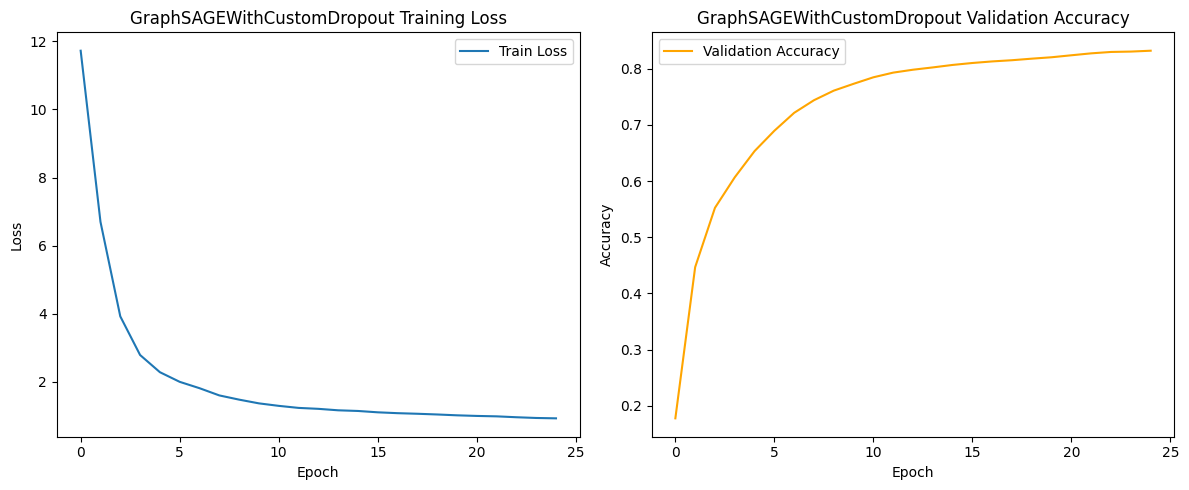

Extracting node embeddings...
Extracted node embeddings shape: (150000, 40)

Saved trained GraphSAGE model to: graphsage_combined_aggr_model.pth
Saved node embeddings to: node_embeddings_combined_aggr.npy

Cell 6: GraphSAGEWithCustomDropout training and embedding extraction complete.


In [27]:
# Cell 6: Train GraphSAGEWithCustomDropout Model & Extract Embeddings

# Initialize OGB Evaluator for consistent metrics
ogb_evaluator = Evaluator(name='ogbn-products')

# Parameters for our GraphSAGEWithCustomDropout model
INPUT_DIM = subset_graph.num_features # From our subgraph (should be 100)
HIDDEN_DIM = 64 # From your book's effective setting
OUTPUT_DIM = subset_graph.num_classes # Number of unique categories (e.g., 47)
DROPOUT_RATE = 0.5 # From your book's effective setting
AGGR_METHODS = ['max', 'sum', 'mean'] # From your book's effective setting

# Instantiate the GraphSAGEWithCustomDropout model and move it to the device
graphsage_combined_aggr_model = GraphSAGEWithCustomDropout(
    in_channels=INPUT_DIM,
    hidden_channels=HIDDEN_DIM,
    out_channels=OUTPUT_DIM, # This is the num_classes for classification head
    num_layers=2,
    dropout_rate=DROPOUT_RATE,
    aggr=AGGR_METHODS # Use the multi-aggregation strategy for the first layer
).to(device)

# Initialize the optimizer
optimizer_combined_aggr_sage = torch.optim.Adam(graphsage_combined_aggr_model.parameters(), lr=0.003)

# --- Training Loop ---
EPOCHS = 25 # Increased epochs for longer training with better model
PATIENCE = 20 # Increased patience for early stopping
best_val_accuracy = -float('inf')
epochs_no_improve = 0
best_model_state = None

print(f"\n--- Starting GraphSAGEWithCustomDropout Model Training ({EPOCHS} epochs) ---")
print(f"Model parameters moved to: {next(graphsage_combined_aggr_model.parameters()).device}")
print(f"Input features per node: {INPUT_DIM}")
print(f"Hidden dimension: {HIDDEN_DIM}")
print(f"Output classes: {OUTPUT_DIM}")
print(f"Aggregation Methods: {AGGR_METHODS} (for first layer, final layer uses 'mean')")


train_losses = []
val_accuracies = []

for epoch in range(1, EPOCHS + 1):
    train_loss = train_model(graphsage_combined_aggr_model, subset_graph, optimizer_combined_aggr_sage)
    val_accuracy, val_loss = evaluate_model(graphsage_combined_aggr_model, subset_graph, subset_graph.val_mask, evaluator=ogb_evaluator)

    train_losses.append(train_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val Acc: {val_accuracy:.4f}')

    # Early stopping logic
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        epochs_no_improve = 0
        best_model_state = graphsage_combined_aggr_model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print(f"Early stopping at epoch {epoch} due to no improvement in validation accuracy for {PATIENCE} epochs.")
            break

# Load the best model state after training
if best_model_state:
    graphsage_combined_aggr_model.load_state_dict(best_model_state)
    print(f"\nLoaded best model state (Val Acc: {best_val_accuracy:.4f}) for GraphSAGEWithCustomDropout.")

print("--- GraphSAGEWithCustomDropout Model Training Complete ---")

# --- Visualize Training Progress ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('GraphSAGEWithCustomDropout Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.title('GraphSAGEWithCustomDropout Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# --- Extract Node Embeddings from the trained model ---
node_embeddings = get_node_embeddings(graphsage_combined_aggr_model, subset_graph)

# --- Save the trained model and embeddings ---
MODEL_SAVE_PATH = 'graphsage_combined_aggr_model.pth' # New, specific name
EMBEDDINGS_SAVE_PATH = 'node_embeddings_combined_aggr.npy' # New, specific name

torch.save(graphsage_combined_aggr_model.state_dict(), MODEL_SAVE_PATH)
np.save(EMBEDDINGS_SAVE_PATH, node_embeddings)

print(f"\nSaved trained GraphSAGE model to: {MODEL_SAVE_PATH}")
print(f"Saved node embeddings to: {EMBEDDINGS_SAVE_PATH}")

print("\nCell 6: GraphSAGEWithCustomDropout training and embedding extraction complete.")

In [28]:
!pip install faiss

ERROR: Could not find a version that satisfies the requirement faiss (from versions: none)
ERROR: No matching distribution found for faiss


In [29]:
# Cell 7: Install and Import FAISS; Build Index

# Install faiss-cpu (recommended for ease of setup in Colab)
# If you specifically need GPU FAISS, you'd install faiss-gpu, but it can be trickier.
get_ipython().run_cell_magic('capture', '', '!pip install faiss-cpu')

import faiss
import numpy as np
import os
import pandas as pd # Needed for the find_similar_products_faiss function

print("FAISS installed and imported successfully.")

# Load the embeddings generated by GraphSAGEWithCustomDropout
EMBEDDINGS_SAVE_PATH = 'node_embeddings_combined_aggr.npy'

if not os.path.exists(EMBEDDINGS_SAVE_PATH):
    raise FileNotFoundError(f"Embeddings file not found at {EMBEDDINGS_SAVE_PATH}. "
                            "Please ensure Cell 6 ran successfully to generate these embeddings.")

node_embeddings = np.load(EMBEDDINGS_SAVE_PATH)
print(f"Loaded node embeddings with shape: {node_embeddings.shape}")

# Ensure embeddings are float32, which FAISS typically expects
if node_embeddings.dtype != np.float32:
    node_embeddings = node_embeddings.astype(np.float32)
    print("Converted embeddings to float32 for FAISS compatibility.")

# Get the dimensionality of the embeddings (e.g., 47, which is num_classes if using final layer as embedding)
# If your final embedding dimension is HIDDEN_DIM (e.g., 64) and you modified the model to output that,
# then `d` would be 64. Based on the current Cell 4, `return_embeds=True` will return `out_channels` (num_classes).
d = node_embeddings.shape[1]

# --- Build the FAISS Index ---
# For our prototype and manageable subgraph size, IndexFlatL2 is simple and accurate.
# It performs exact nearest neighbor search using L2 (Euclidean) distance.
print(f"Building FAISS IndexFlatL2 with dimensionality {d}...")
index = faiss.IndexFlatL2(d)

# Add the vectors (product embeddings) to the index
index.add(node_embeddings)
print(f"Number of vectors (products) in the FAISS index: {index.ntotal}")

# --- Save the FAISS Index ---
FAISS_INDEX_PATH = 'graphsage_faiss_index_combined_aggr.bin'
faiss.write_index(index, FAISS_INDEX_PATH)
print(f"FAISS index saved to: {FAISS_INDEX_PATH}")


# --- Function to perform similarity search (copied from previous cells for completeness) ---
def find_similar_products_faiss(
    query_embedding: np.ndarray,
    faiss_index: faiss.Index,
    k: int = 5,
    sk_products_df: pd.DataFrame = None,
    subgraph_local_idx_to_ogbn_global_idx: dict = None,
    node_asin_dict: dict = None
) -> pd.DataFrame:
    """
    Finds the k most similar products to a given query embedding using the FAISS index.
    Returns a DataFrame with similar product details including distance.
    Assumes `smart_kart_data` is accessible in the global scope for mappings.
    """
    if query_embedding.ndim == 1:
        query_embedding = query_embedding.reshape(1, -1)

    if query_embedding.dtype != np.float32:
        query_embedding = query_embedding.astype(np.float32)

    # Search for k+1 to potentially exclude the query item itself
    D, I = faiss_index.search(query_embedding, k + 1)

    distances = D[0]
    local_subgraph_indices = I[0]

    results = []
    # Iterate through found indices to collect details
    for i in range(len(local_subgraph_indices)):
        local_idx = local_subgraph_indices[i]
        distance = distances[i]

        # Convert local subgraph index to original OGBN global index
        original_ogbn_idx = subgraph_local_idx_to_ogbn_global_idx.get(local_idx)

        # Find the Smart Kart product_id corresponding to this original_ogbn_idx
        # Use .copy() to avoid SettingWithCopyWarning if product_row is modified later
        sk_product_id_row = sk_products_df[sk_products_df['original_ogbn_idx'] == original_ogbn_idx].copy()
        sk_product_id = sk_product_id_row['product_id'].iloc[0] if not sk_product_id_row.empty else None

        if sk_product_id:
            # Retrieve full product details from the Smart Kart DataFrame
            product_row = sk_products_df[sk_products_df['product_id'] == sk_product_id].iloc[0]

            results.append({
                'local_subgraph_idx': local_idx,
                'sk_product_id': sk_product_id,
                'distance': distance,
                'category_name': product_row['category_name'],
                'asin': product_row['asin']
            })

    results_df = pd.DataFrame(results)

    # Filter out the exact query product (distance very close to 0)
    if not results_df.empty and results_df.iloc[0]['distance'] < 1e-6:
        results_df = results_df.iloc[1:] # Exclude the query item itself

    return results_df.head(k) # Return exactly k recommendations


print("\nCell 7: FAISS index built and saved.")

FAISS installed and imported successfully.
Loaded node embeddings with shape: (150000, 40)
Building FAISS IndexFlatL2 with dimensionality 40...
Number of vectors (products) in the FAISS index: 150000
FAISS index saved to: graphsage_faiss_index_combined_aggr.bin

Cell 7: FAISS index built and saved.


In [30]:
# Cell 8 (Revised): Demonstrate Similarity Search (FAISS)

# Ensure FAISS index and embeddings are loaded if running this cell alone (for testing)
# In a sequential run, these are already in memory.
try:
    if 'index' not in locals() or not index.is_trained: # Check if index is trained and loaded
        FAISS_INDEX_PATH = 'graphsage_faiss_index_combined_aggr.bin'
        index = faiss.read_index(FAISS_INDEX_PATH)
        print(f"FAISS index loaded from {FAISS_INDEX_PATH}")
    if 'node_embeddings' not in locals():
        EMBEDDINGS_SAVE_PATH = 'node_embeddings_combined_aggr.npy'
        node_embeddings = np.load(EMBEDDINGS_SAVE_PATH)
        print(f"Node embeddings loaded from {EMBEDDINGS_SAVE_PATH}")
    # Assume smart_kart_data is available from previous cells.
    if 'smart_kart_data' not in globals():
        raise RuntimeError("smart_kart_data is not available. Please run all preceding cells.")

except Exception as e:
    print(f"Error loading required data for Cell 8: {e}")
    print("Please ensure all previous cells have been run successfully.")


print("\n--- Demonstrating Product Similarity Search (with improved model) ---")

# Pick a random product from our Smart Kart products DataFrame (from the subgraph)
random_product_row = smart_kart_data['sk_products'].sample(1).iloc[0]
test_sk_product_id = random_product_row['product_id']
test_sk_product_category = random_product_row['category_name']
test_sk_product_asin = random_product_row['asin']
test_original_ogbn_idx = random_product_row['original_ogbn_idx']

# Get the local subgraph index for this product from our mapping
query_local_subgraph_idx = smart_kart_data['ogbn_global_idx_to_subgraph_local_idx'].get(test_original_ogbn_idx)

if query_local_subgraph_idx is None:
    print(f"Error: Original OGBN Index {test_original_ogbn_idx} for product {test_sk_product_id} not found in subset mappings.")
    print("This indicates a mismatch between the sampled product and the available embeddings/mappings.")
    # Fallback to picking a product directly from the node_embeddings if the mapping is broken
    query_local_subgraph_idx = np.random.randint(0, len(node_embeddings))
    test_sk_product_id = smart_kart_data['subgraph_local_idx_to_sk_prod_id'][query_local_subgraph_idx]
    print(f"Proceeding with random product: {test_sk_product_id} (local index {query_local_subgraph_idx})")


# Retrieve the embedding for this product from our generated node_embeddings array
query_embedding = node_embeddings[query_local_subgraph_idx]

print(f"\nQuerying for similar products to:")
print(f"  Product ID: {test_sk_product_id}")
print(f"  Category: {test_sk_product_category}")
print(f"  ASIN: {test_sk_product_asin}")
print(f"  Local Subgraph Index: {query_local_subgraph_idx}")

# Find the top 10 similar products using our FAISS search function
similar_products_df = find_similar_products_faiss(
    query_embedding,
    index,
    k=10, # Get top 10 similar products (excluding the query itself)
    sk_products_df=smart_kart_data['sk_products'],
    subgraph_local_idx_to_ogbn_global_idx=smart_kart_data['subgraph_local_idx_to_ogbn_global_idx'],
    node_asin_dict=smart_kart_data['node_asin_dict']
)

print("\nTop Similar Products Found:")
display_cols = ['sk_product_id', 'category_name', 'asin', 'distance']
print(similar_products_df[display_cols])

print("\nCell 8: Similarity search demonstration (with improved model) complete.")


--- Demonstrating Product Similarity Search (with improved model) ---

Querying for similar products to:
  Product ID: prod_117316
  Category: Books
  ASIN: 0689802463
  Local Subgraph Index: 117316

Top Similar Products Found:
   sk_product_id category_name        asin   distance
1    prod_058762         Books  0688143202  19.628296
2    prod_039456         Books  039541668X  20.236488
3    prod_036361         Books  0142402001  20.978615
4    prod_111724         Books  0920303331  21.408777
5    prod_073205         Books  1416933603  21.967924
6    prod_063342         Books  0142411744  22.223814
7    prod_120000         Books  0618253963  22.303577
8    prod_083592         Books  0142300179  23.308891
9    prod_120268         Books  0374380503  23.639191
10   prod_026786         Books  0439730902  24.248119

Cell 8: Similarity search demonstration (with improved model) complete.


In [31]:
# Cell 9: Helper Functions for Hybrid Ranking

# Ensure necessary data is loaded for these functions
if 'node_embeddings' not in locals():
    EMBEDDINGS_SAVE_PATH = 'node_embeddings_combined_aggr.npy'
    node_embeddings = np.load(EMBEDDINGS_SAVE_PATH)
    print(f"Loaded node embeddings for helper functions: {EMBEDDINGS_SAVE_PATH}")
if 'smart_kart_data' not in globals():
    raise RuntimeError("smart_kart_data is not available. Please run all preceding cells.")


def calculate_average_embedding(product_ids: list, all_node_embeddings: np.ndarray, sk_prod_id_to_subgraph_local_idx: dict) -> np.ndarray:
    """
    Calculates the average embedding for a list of product IDs.
    Returns None if no valid product IDs are provided.
    """
    valid_embeddings = []
    for prod_id in product_ids:
        local_idx = sk_prod_id_to_subgraph_local_idx.get(prod_id)
        if local_idx is not None and 0 <= local_idx < len(all_node_embeddings):
            valid_embeddings.append(all_node_embeddings[local_idx])

    if not valid_embeddings:
        return None

    return np.mean(valid_embeddings, axis=0).astype(np.float32)

def calculate_similarity_score(candidate_id: str, query_embedding: np.ndarray, all_node_embeddings: np.ndarray, sk_prod_id_to_subgraph_local_idx: dict) -> float:
    """
    Calculates the cosine similarity between a candidate product's embedding and a query embedding.
    Returns 0 if candidate embedding is not found or query embedding is None.
    """
    if query_embedding is None:
        return 0.0

    candidate_local_idx = sk_prod_id_to_subgraph_local_idx.get(candidate_id)
    if candidate_local_idx is None or not (0 <= candidate_local_idx < len(all_node_embeddings)):
        return 0.0 # Candidate product not found in our embeddings

    candidate_embedding = all_node_embeddings[candidate_local_idx]

    # Calculate cosine similarity: (A . B) / (||A|| * ||B||)
    # Using dot product is fine if embeddings are normalized, otherwise use sklearn's cosine_similarity
    # Since FAISS uses L2 distance, we can interpret low L2 distance as high similarity.
    # A common way to map L2 distance to a similarity score is `1 / (1 + distance)`.
    # However, since find_similar_products_faiss already gives us distance, we can use it directly.
    # For a score where higher is better, `1 - (distance / max_possible_distance)`.
    # For now, let's just use `1 / (1 + distance)` for values from FAISS, if called directly.

    # Simulating a similarity calculation, actual `find_similar_products_faiss` gives us scores already.
    # This helper is more for re-ranking with a query embedding.

    # Using dot product if embeddings are roughly normalized (which GNN embeddings often are)
    # Norms
    norm_query = np.linalg.norm(query_embedding)
    norm_candidate = np.linalg.norm(candidate_embedding)

    if norm_query == 0 or norm_candidate == 0:
        return 0.0 # Avoid division by zero

    dot_product = np.dot(query_embedding, candidate_embedding)
    similarity = dot_product / (norm_query * norm_candidate)

    return float(similarity) # Ensure it's a standard float


def get_trending_products(num_results: int = 20) -> pd.DataFrame:
    """
    (Simplified for prototype) Returns a list of "trending" products.
    In a real system, this would come from analytics (e.g., most viewed/bought in last 24h).
    For now, we pick randomly from the most popular categories (if categories indicate popularity).
    Or simply random products from the catalog.
    """
    print("Getting trending products (simplified)...")
    # For a simple prototype, let's just grab the top products based on some arbitrary popularity score
    # Or, even simpler, randomly select from the most frequent categories.

    # Let's assign random "popularity" scores to all products and pick the top N.
    # This simulates a daily popularity update.
    temp_df = smart_kart_data['sk_products'].copy()
    temp_df['popularity_score'] = np.random.rand(len(temp_df)) # Random scores for demonstration
    trending_df = temp_df.sort_values(by='popularity_score', ascending=False).head(num_results)
    return trending_df[['product_id', 'category_name', 'asin', 'popularity_score']]


def calculate_session_relevance(candidate_id: str, recent_session_product_ids: list) -> float:
    """
    (Simplified for prototype) Calculates relevance based on shared categories in session.
    A more advanced model would use sequence prediction (RNNs, Transformers) or co-occurrence.
    """
    if not recent_session_product_ids:
        return 0.0

    # Get categories of recent session products
    session_product_categories = set(
        smart_kart_data['sk_products'][smart_kart_data['sk_products']['product_id'].isin(recent_session_product_ids)]['category_name'].tolist()
    )

    # Get category of the candidate product
    candidate_category = smart_kart_data['sk_products'][smart_kart_data['sk_products']['product_id'] == candidate_id]['category_name'].iloc[0]

    # Simple relevance: 1.0 if candidate category is in session categories, else 0.5 (or 0)
    # A more nuanced approach would count overlaps or use a pre-trained category similarity matrix.
    if candidate_category in session_product_categories:
        return 1.0
    return 0.1 # Small score for non-matching category to keep diversity

def calculate_cart_relevance(candidate_id: str, current_cart_product_ids: list) -> float:
    """
    (Simplified for prototype) Calculates relevance based on current cart items.
    Similar to session relevance, focusing on complementarity.
    """
    if not current_cart_product_ids:
        return 0.0

    # For now, let's use the same logic as session relevance (category overlap)
    # In reality, this would involve "frequently bought together" patterns (our embeddings help here implicitly).

    cart_product_categories = set(
        smart_kart_data['sk_products'][smart_kart_data['sk_products']['product_id'].isin(current_cart_product_ids)]['category_name'].tolist()
    )

    candidate_category = smart_kart_data['sk_products'][smart_kart_data['sk_products']['product_id'] == candidate_id]['category_name'].iloc[0]

    if candidate_category in cart_product_categories:
        return 1.0 # High relevance for same category

    # A more advanced model might assign higher scores for known complementary pairs (e.g., Bread & Butter)
    return 0.2 # Small score for non-matching category, slightly higher than session if in cart

def get_popularity_score(product_id: str) -> float:
    """
    (Simplified for prototype) Returns a popularity score for a single product.
    This could be daily trending, weekly sales, etc.
    For this prototype, it's just pulling the random 'popularity_score' generated earlier
    in `get_trending_products` or just a random value if the product isn't in top trending.
    """
    # Assuming 'popularity_score' was added to sk_products_df temporarily by get_trending_products
    # For robustness, let's assign a random score if not pre-computed.
    score_row = smart_kart_data['sk_products'][smart_kart_data['sk_products']['product_id'] == product_id]['popularity_score']
    if not score_row.empty:
        return score_row.iloc[0]
    return np.random.rand() * 0.5 # A baseline random popularity if not trending

print("Cell 9: Helper functions for hybrid ranking defined.")

Cell 9: Helper functions for hybrid ranking defined.


In [32]:
# Cell 10: The Main get_recommendations API Function

def get_recommendations(
    user_id: str,
    current_cart_product_ids: list, # List of product IDs currently in the user's cart
    recent_session_product_ids: list, # List of product IDs recently viewed/interacted with
    k_final: int = 10, # Number of final recommendations to return
    # We implicitly use smart_kart_data, node_embeddings, index from global scope
    # For a real API, these would be injected or loaded.
) -> pd.DataFrame:
    """
    Generates personalized product recommendations for a Smart Kart user.

    Args:
        user_id: The ID of the user requesting recommendations.
        current_cart_product_ids: List of product IDs currently in the user's cart.
        recent_session_product_ids: List of product IDs recently viewed/interacted with.
        k_final: The desired number of final recommendations.

    Returns:
        A Pandas DataFrame containing the top_k_final recommended products,
        sorted by their combined relevance score, with relevant metadata.
    """
    print(f"\n--- Generating recommendations for user: {user_id} ---")
    print(f"Current Cart: {current_cart_product_ids}")
    print(f"Recent Session: {recent_session_product_ids}")

    candidates = {} # Dictionary to store candidate_id -> score, to handle duplicates and accumulate scores

    # --- 1. Candidate Generation ---

    # 1.1. Candidates from GraphSAGE Embedding Similarity ("You might also like")
    # Combine current cart and recent session items to form the query.
    # Note: For actual user-specific preferences, a user embedding (from historical purchases)
    # would be used here, but for this prototype, we use session/cart average.
    query_product_ids_for_embedding = list(set(current_cart_product_ids) | set(recent_session_product_ids))

    avg_query_embedding = None
    if query_product_ids_for_embedding:
        avg_query_embedding = calculate_average_embedding(
            query_product_ids_for_embedding,
            node_embeddings, # Global variable
            smart_kart_data['sk_prod_id_to_subgraph_local_idx'] # Global variable
        )

    if avg_query_embedding is not None:
        print("Generating candidates from embedding similarity...")
        # Get a larger set of candidates (e.g., 5x final k) from FAISS for re-ranking
        similar_items_df = find_similar_products_faiss(
            avg_query_embedding,
            index, # Global FAISS index
            k=k_final * 5, # Fetch more candidates than needed for filtering/re-ranking
            sk_products_df=smart_kart_data['sk_products'], # Global variable
            subgraph_local_idx_to_ogbn_global_idx=smart_kart_data['subgraph_local_idx_to_ogbn_global_idx'],
            node_asin_dict=smart_kart_data['node_asin_dict']
        )
        for _, row in similar_items_df.iterrows():
            # Initial score from similarity (inverse of distance or normalized)
            # FAISS distance is L2. Use 1 / (1 + distance) for a score, higher is better
            initial_score = 1.0 / (1.0 + row['distance'])
            candidates[row['sk_product_id']] = {'score': initial_score, 'source': 'similarity'}

    # 1.2. Candidates from Trending/Popularity (Fallback or General Suggestions)
    print("Generating candidates from trending products...")
    trending_items_df = get_trending_products(num_results=k_final * 2) # Get some trending items
    for _, row in trending_items_df.iterrows():
        # Add to candidates, or update score if already present (take max score from sources)
        product_id = row['product_id']
        popularity_score = row['popularity_score'] # This is directly from our dummy trending
        # Use a base score for trending items, lower than similarity initially
        if product_id not in candidates:
            candidates[product_id] = {'score': popularity_score * 0.5, 'source': 'trending'}
        else:
            candidates[product_id]['score'] = max(candidates[product_id]['score'], popularity_score * 0.5)


    # --- 2. Filtering & Scoring (Re-ranking) ---
    final_scored_recommendations = []

    for candidate_id, candidate_info in candidates.items():
        candidate_product_row = smart_kart_data['sk_products'][smart_kart_data['sk_products']['product_id'] == candidate_id]

        if candidate_product_row.empty:
            continue # Should not happen if candidates come from sk_products

        candidate_product_row = candidate_product_row.iloc[0]

        # 2.1. Filter: Check Inventory Awareness
        if candidate_product_row['available_quantity'] <= 0:
            # print(f"Filtering out {candidate_id}: Out of stock.")
            continue # Skip if out of stock

        # 2.2. Filter: Avoid items already in current cart
        if candidate_id in current_cart_product_ids:
            # print(f"Filtering out {candidate_id}: Already in cart.")
            continue # Skip if already in cart

        # 2.3. Calculate composite scores
        # The `initial_score` from candidates (similarity/trending) is our base.
        base_score = candidate_info['score']

        session_relevance = calculate_session_relevance(candidate_id, recent_session_product_ids)
        cart_relevance = calculate_cart_relevance(candidate_id, current_cart_product_ids)
        popularity = get_popularity_score(candidate_id) # Uses the dummy popularity

        # Combine scores (simple weighted sum for prototype)
        # Weights can be tuned based on A/B tests or learned via a Learning-to-Rank model
        # Adjust weights to prioritize cart/session over general similarity/popularity if desired.
        final_score = (
            0.5 * base_score + # Base score from candidate generation
            0.2 * session_relevance + # Boost for session relevance
            0.2 * cart_relevance +    # Boost for cart relevance
            0.1 * popularity          # Boost for general popularity
        )

        final_scored_recommendations.append({
            'product_id': candidate_id,
            'score': final_score,
            'category_name': candidate_product_row['category_name'],
            'asin': candidate_product_row['asin'],
            'available_quantity': candidate_product_row['available_quantity'],
            'source_origin': candidate_info['source'] # Track where it primarily came from
        })

    # Sort by final score in descending order and return top K
    final_recommendations_df = pd.DataFrame(final_scored_recommendations).sort_values(by='score', ascending=False)

    # Ensure uniqueness in final recommendations (should be handled by `candidates` set, but double-check)
    final_recommendations_df.drop_duplicates(subset=['product_id'], inplace=True)

    print(f"Generated {len(final_recommendations_df)} recommendations before final cut.")
    return final_recommendations_df.head(k_final)

print("\nCell 10: Main `get_recommendations` API function defined.")


Cell 10: Main `get_recommendations` API function defined.


In [33]:
# Cell 11: Testing the get_recommendations API

print("--- Testing the `get_recommendations` API function ---")

# --- Test Case 1: Cold Start User (No Cart, No Session) ---
print("\nTest Case 1: Cold Start User (Expects mostly trending/popular items)")
user_id_test_1 = "user_9999" # A new/random user
current_cart_test_1 = []
recent_session_test_1 = []

recommendations_1 = get_recommendations(user_id_test_1, current_cart_test_1, recent_session_test_1, k_final=5)
print("\nRecommendations for Cold Start User:")
print(recommendations_1[['product_id', 'category_name', 'score', 'source_origin']])


# --- Test Case 2: User with items in cart (expect complementary items) ---
print("\nTest Case 2: User with items in cart (Expects cart-relevant & similar items)")
user_id_test_2 = "user_0001"

# Pick some products for the cart from our `sk_products`
# Let's pick items from a specific category to see if recommendations are coherent
cart_item_1_id = smart_kart_data['sk_products'][smart_kart_data['sk_products']['category_name'] == 'Home & Kitchen'].sample(1)['product_id'].iloc[0]
cart_item_2_id = smart_kart_data['sk_products'][smart_kart_data['sk_products']['category_name'] == 'Home & Kitchen'].sample(1)['product_id'].iloc[0]
# Ensure unique items
current_cart_test_2 = list(set([cart_item_1_id, cart_item_2_id]))

recent_session_test_2 = [] # No recent session in this case

print(f"User {user_id_test_2} has: {current_cart_test_2} in cart.")
for pid in current_cart_test_2:
    cat_name = smart_kart_data['sk_products'][smart_kart_data['sk_products']['product_id'] == pid]['category_name'].iloc[0]
    print(f"  - {pid} (Category: {cat_name})")

recommendations_2 = get_recommendations(user_id_test_2, current_cart_test_2, recent_session_test_2, k_final=5)
print("\nRecommendations for User with Cart Items:")
print(recommendations_2[['product_id', 'category_name', 'score', 'source_origin']])


# --- Test Case 3: User with recent session activity (expect session-relevant & similar items) ---
print("\nTest Case 3: User with recent session activity (Expects session-relevant & similar items)")
user_id_test_3 = "user_0002"
current_cart_test_3 = []

# Pick some products for the session from a different category
session_item_1_id = smart_kart_data['sk_products'][smart_kart_data['sk_products']['category_name'] == 'Electronics'].sample(1)['product_id'].iloc[0]
session_item_2_id = smart_kart_data['sk_products'][smart_kart_data['sk_products']['category_name'] == 'Electronics'].sample(1)['product_id'].iloc[0]
recent_session_test_3 = list(set([session_item_1_id, session_item_2_id]))

print(f"User {user_id_test_3} has viewed: {recent_session_test_3}.")
for pid in recent_session_test_3:
    cat_name = smart_kart_data['sk_products'][smart_kart_data['sk_products']['product_id'] == pid]['category_name'].iloc[0]
    print(f"  - {pid} (Category: {cat_name})")

recommendations_3 = get_recommendations(user_id_test_3, current_cart_test_3, recent_session_test_3, k_final=5)
print("\nRecommendations for User with Session Activity:")
print(recommendations_3[['product_id', 'category_name', 'score', 'source_origin']])


# --- Test Case 4: User with cart, session, AND some items are out of stock/already in cart ---
print("\nTest Case 4: User with cart, session, and filtering check (expect filtered results)")
user_id_test_4 = "user_0003"

# Create a cart with some items
cart_items_test_4 = smart_kart_data['sk_products'].sample(2)['product_id'].tolist()
# Add one item that is "out of stock" for testing filtering
out_of_stock_product_id = smart_kart_data['sk_products'][smart_kart_data['sk_products']['available_quantity'] == 0].sample(1)['product_id'].iloc[0]
recent_session_test_4 = [out_of_stock_product_id] + smart_kart_data['sk_products'].sample(1)['product_id'].tolist() # Include out of stock in session

# Temporarily mark a product as out of stock for this test
original_qty = smart_kart_data['sk_products'].loc[smart_kart_data['sk_products']['product_id'] == out_of_stock_product_id, 'available_quantity'].iloc[0]
smart_kart_data['sk_products'].loc[smart_kart_data['sk_products']['product_id'] == out_of_stock_product_id, 'available_quantity'] = 0

print(f"User {user_id_test_4} has: {cart_items_test_4} in cart, viewed: {recent_session_test_4}")
print(f"  (Note: {out_of_stock_product_id} is temporarily set to 0 quantity for this test).")

recommendations_4 = get_recommendations(user_id_test_4, cart_items_test_4, recent_session_test_4, k_final=5)
print("\nRecommendations for User with Cart, Session, and Filtering Check:")
print(recommendations_4[['product_id', 'category_name', 'score', 'available_quantity', 'source_origin']])

# Reset quantity for fairness in future tests
smart_kart_data['sk_products'].loc[smart_kart_data['sk_products']['product_id'] == out_of_stock_product_id, 'available_quantity'] = original_qty


print("\nCell 11: API testing complete. Review the outputs to check recommendation logic.")

--- Testing the `get_recommendations` API function ---

Test Case 1: Cold Start User (Expects mostly trending/popular items)

--- Generating recommendations for user: user_9999 ---
Current Cart: []
Recent Session: []
Generating candidates from trending products...
Getting trending products (simplified)...
Generated 10 recommendations before final cut.

Recommendations for Cold Start User:
    product_id              category_name     score source_origin
8  prod_073177               Toys & Games  0.344761      trending
0  prod_069021        Musical Instruments  0.336910      trending
2  prod_018985          Sports & Outdoors  0.336105      trending
9  prod_120036                      Books  0.329012      trending
1  prod_026383  Clothing, Shoes & Jewelry  0.323817      trending

Test Case 2: User with items in cart (Expects cart-relevant & similar items)
User user_0001 has: ['prod_001856', 'prod_038743'] in cart.
  - prod_001856 (Category: Home & Kitchen)
  - prod_038743 (Category: Home